# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# imports
from collections import deque
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from calibration import Calibration
from utils import *
from preprocessing import *
from LaneDetector import *

In [2]:
# sample images
test_images = glob.glob('test_images/*.jpg')
video_images = glob.glob('test_images/video_samples/*.jpg')
project_images = glob.glob('test_images/video_samples/project*.jpg')
challange_images = glob.glob('test_images/video_samples/challange*.jpg')
harder_challange_images = glob.glob('test_images/video_samples/harder_challange*.jpg')

In [3]:
cal = Calibration(nx=9, ny=6)
cal.compute_cal('camera_cal/calibration*.jpg')
M, M_inv = get_prespective_transform(ROI_SRC, ROI_DST)

Loaded camera config from file: calibration.pkl


In [4]:
def process_img(img):
    # undistort
    dst = cal.undistort(img)    
    # color threshold 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_mask = preprocessing.or_masks(preprocessing.color_threshold_image3(hls, preprocessing.HLS_THRESHOLD[0]), 
                                      preprocessing.color_threshold_image3(hls, preprocessing.HLS_THRESHOLD[1]))
    # gradient threshold
    red_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    gradient_mask = preprocessing.gradient_threshold(red_channel, 
                                                     kernel_size=preprocessing.GRADIENT_KERNEL_SIZE,
                                                     thresholds=preprocessing.GRADIENT_THRESHOLD)
    # combine thresholds
    mask = preprocessing.or_masks(hls_mask, gradient_mask)
    # roi
    roi = preprocessing.roi(mask, preprocessing.ROI_SRC)
    # warp image
    warped = preprocessing.warp_image(roi, M)
    return warped

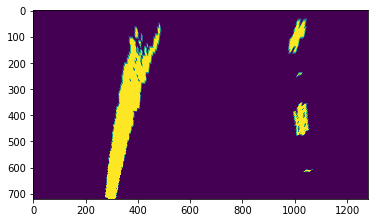

In [5]:
plt.imshow(process_img(mpimg.imread(test_images[0])))

## Lane detection

In [6]:
def find_lane_pixels(img, nwindows=9, margin=150, minpix=50):
    '''
    Searches mask image for lanes
    '''
    # Create histogram of image binary activations
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin
        win_xright_high = rightx_current+margin

        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return (leftx, lefty), (rightx, righty), (leftx_base, rightx_base)

def fit_polynomial(x, y):
    '''
    fit line to pixels
    '''
    # Fit a second order polynomial to each using `np.polyfit`
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            return np.polyfit(y, x, 2)
        except np.RankWarning:
            return None

def measure_curvature(y, line_eq):
    '''
    Calculates the curvature of polynomial functions.
    '''
    # calculation of R_curve (radius of curvature)
    return ((1 + (2*y*line_eq[0]+line_eq[1])**2)**(3/2))/np.absolute(2*line_eq[0])

def cvt_line_to_meters(line_eq, xm, ym):
    '''
    cvt line from pixels to meters
    '''
    new_line = np.copy(line_eq)
    new_line[0] *= xm/(ym**2)
    new_line[1] *= xm/ym
    return new_line

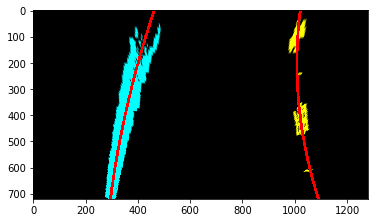

In [7]:
# test lane points

img = mpimg.imread(test_images[0])
mask = process_img(img)
left_points, right_points, base_loc = find_lane_pixels(mask)

left_lane = fit_polynomial(left_points[0], left_points[1])
right_lane = fit_polynomial(right_points[0], right_points[1])
plt.imshow(plot_lane_lines(mask, left_points, left_lane, right_points, right_lane))

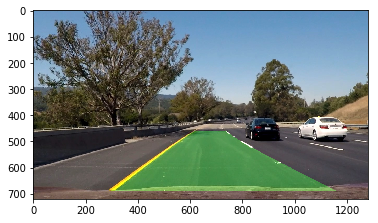

In [8]:
lane_image = draw_lanes(img, left_lane, right_lane, M_inv)
# Combine the result with the original image
result = cv2.addWeighted(img, 1, lane_image, 0.3, 0)
plt.imshow(result)

## Smoothing lanes 

In [9]:
class LaneHistory:
    def __init__(self, history_steps=25, error_limit=100):
        self.lines = deque(maxlen=history_steps)
        self.smoothed_line = None
        self.diff = []
        self.error_limit = error_limit
        
    def append(self, line):
        if self.smoothed_line is not None:
            if self.error(line) > self.error_limit:
                # bad line don't use
                return False
        self.lines.append(line)
        self.compute_average()
        return True
    
    def compute_average(self):
        if len(self.lines) == 0:
            return
        else:
            self.smoothed_line = np.mean(self.lines, axis=0)
            
    def get_line(self):
        return self.smoothed_line
    
    def error(self, line):
        return np.absolute(self.norm(line) - self.norm(self.smoothed_line))
    
    def norm(self, x):
        return np.sqrt(x[0]**2+x[1]**2+x[2]**2)

Test smoothing

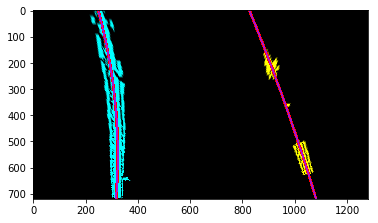

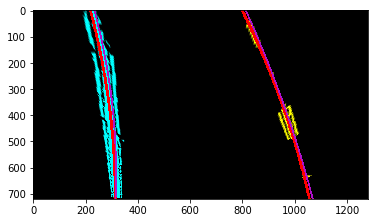

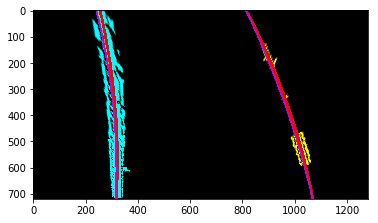

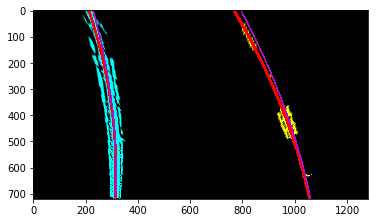

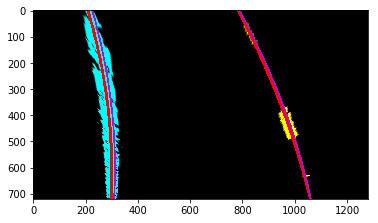

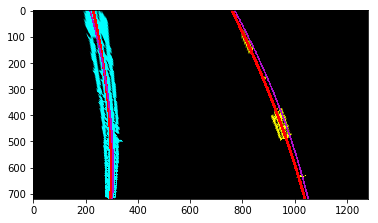

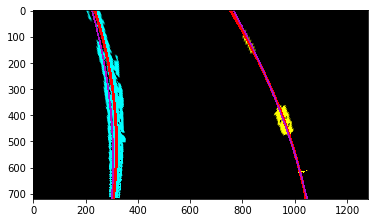

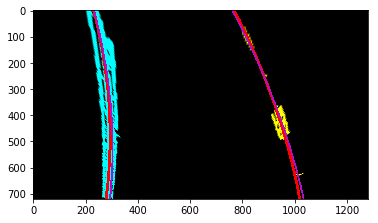

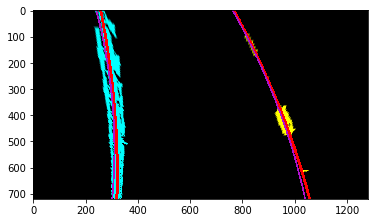

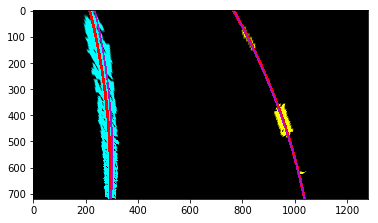

In [10]:
left_lane = LaneHistory(3)
right_lane = LaneHistory(3)

for fname in video_images:
    img = mpimg.imread(fname)
    mask = process_img(img)
    left_points, right_points, base_loc = find_lane_pixels(mask)

    left_fit = fit_polynomial(left_points[0], left_points[1])
    left_lane.append(left_fit)
    right_fit = fit_polynomial(right_points[0], right_points[1])
    right_lane.append(right_fit)
    plt.imshow(plot_lane_lines(mask, left_points, left_fit, right_points, right_fit, left_lane.get_line(), right_lane.get_line()))
    plt.show()

## Complete algorithm

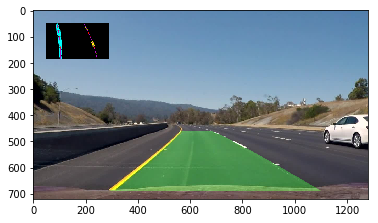

In [11]:
# pixels to meters
xm = 3.7/800
ym = 32/720

left_lane = LaneHistory(5)
right_lane = LaneHistory(5)

def lane_detection(img, debug=True):
    # get mask
    mask = process_img(img)
    
    # find line
    left_points, right_points, base_loc = find_lane_pixels(mask)
    left_fit = fit_polynomial(left_points[0], left_points[1])
    right_fit = fit_polynomial(right_points[0], right_points[1])
    left_lane.append(left_fit)
    right_lane.append(right_fit)
    
    # draw lane image
    lane_image = draw_lanes(img, left_lane.get_line(), right_lane.get_line(), M_inv)
    result = cv2.addWeighted(img, 1, lane_image, 0.3, 0)
    
    if debug:
        debug_img = plot_lane_lines(mask, left_points, left_fit, right_points, right_fit, left_lane.get_line(), right_lane.get_line())
        result = embed_image(result, debug_img)
    return result

plt.imshow(lane_detection(img))

## Process project video

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
clip = VideoFileClip("test_videos/project_video.mp4")
output = clip.fl_image(lane_detection)
output.write_videofile('output.mp4', audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:40<00:00,  4.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output.mp4'))